# Guided Project - Building Handwritten Digits Classifier
## Project Introduction
In this project we are going to work on building an image classifier that will learn how to classify handwritten digits:
- explore why image classification is a hard task
- observe the limitations of traditional machine learning models for image classification
- train, test, and improve a few different deep neural networks for image classification

### Why is image classification a hard task?
Within the field of machine learning and pattern recognition, image classification (especially for handwritten text) is towards the difficult end of the spectrum. There are a few reasons for this:
1. First, each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. This means that a 128 x 128 image has 16384 features.
2. Second, images are often downsampled to lower resolutions and transformed to grayscale (no color). This is a limitation of compute power unfortunately. The resolution of a 8 megapixel photo has 3264 by 2448 pixels, for a total of 7,990,272 features (or about 8 million). Images of this resolution are usually scaled down to between 128 and 512 pixels in either direction for significantly faster processing. This often results in a loss of detail that's available for training and pattern matching.
3. Third, the features in an image don't have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression. In grayscale, each pixel is just represented as a brightness value ranging from 0 to 256.

### Why is deep learning effective in image classification?
Deep learning is effective in image classification because of the models' ability to learn hierarchical representations. At a high level, an effective deep learning model learns intermediate representations at each layer in the model and uses them in the prediction process. Here's a diagram that visualizes what the weights represent at each layer of a convolutional neural network, a type of network that's often used in image classification and unfortunately out of scope for this course, which was trained to identify faces.

## Import Libraries & Initial EDA

In [1]:
# import libraries
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
%matplotlib inline

digits_data = load_digits()

In [2]:
# check data
digits_data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
# get features and labels
digits_df = pd.DataFrame(digits_data['data'])
labels = pd.Series(digits_data['target'])

In [4]:
# check features first rows
digits_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [5]:
# check labels first rows
labels.head()

0    0
1    1
2    2
3    3
4    4
dtype: int64

Because dataframes are a tabular representation of data, each image is represented as a row of pixel values. To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (28 x 28 pixels). To visualize the image, we need to reshape these pixel values back into the 28 by 28 and plot them on a coordinate grid.

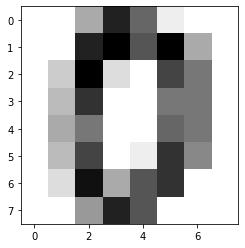

In [6]:
# reshape data into digits
first_image = digits_df.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)
# use imshow to display image
plt.imshow(np_image, cmap='gray_r')

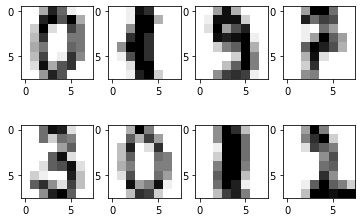

In [7]:
# display specific rows of the dataset
f, axarr = plt.subplots(2, 4)

axarr[0, 0].imshow(digits_df.iloc[0].values.reshape(8,8), cmap='gray_r')
axarr[0, 1].imshow(digits_df.iloc[99].values.reshape(8,8), cmap='gray_r')
axarr[0, 2].imshow(digits_df.iloc[199].values.reshape(8,8), cmap='gray_r')
axarr[0, 3].imshow(digits_df.iloc[299].values.reshape(8,8), cmap='gray_r')

axarr[1, 0].imshow(digits_df.iloc[999].values.reshape(8,8), cmap='gray_r')
axarr[1, 1].imshow(digits_df.iloc[1099].values.reshape(8,8), cmap='gray_r')
axarr[1, 2].imshow(digits_df.iloc[1199].values.reshape(8,8), cmap='gray_r')
axarr[1, 3].imshow(digits_df.iloc[1299].values.reshape(8,8), cmap='gray_r')

## KNN Model
The KNN model is a non-linear model which is more an algorithm than a model.
KNN compares observations in the test set to that of those in the training set.
The algorithm looks for similar observations in the training set with that of test set.
Linear and logistic regression models assume linearity between the features and the target.
The algorithm finds label with the most nearby observation and assigns that as prediction to the unseen observation
Initiate KNN Model. Split train and test.

In [8]:
# split trsin and test
def train_knn(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test_knn(model, test_features, test_labels):
    knn_predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct label'] = test_labels
    train_test_df['predicted label'] = knn_predictions
    knn_accuracy = sum(train_test_df['correct label'] == train_test_df['predicted label']) / len(train_test_df)
    return knn_accuracy

def cross_validate(k):
    fold_accuracies =[]
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(digits_df):
        train_features, test_features = digits_df.loc[train_index], digits_df.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_knn(k, train_features, train_labels)
        overall_accuracy = test_knn(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies
knn_one_accuracies = cross_validate(1)
np.mean(knn_one_accuracies)

0.9888728037614452

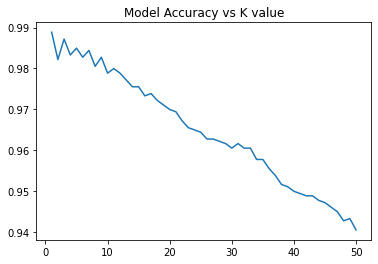

In [9]:
# test different values of K
k_values = list(range(1,51))
k_overall_accuracies = []
for k in k_values:
    k_accuracies = cross_validate(k)
    k_mean_accuracy = np.mean(k_accuracies)
    k_overall_accuracies.append(k_mean_accuracy)
plt.plot(k_values, k_overall_accuracies)
plt.title('Model Accuracy vs K value')
plt.show()

### Demerits of KNN
The unseen observation makes many comparisons to seen observations resulting in high memory usage
There is no debug and explore possible as it lacks model representation

### Single Hidden Layer Neural Networks (SHL)
Train and test neural network with following single hidden layers using 4-fold cross validation:
- SHL of 8 neurons
- SHL of 16 neurons
- SHL of 32 neurons
- SHL of 64 neurons
- SHL of 128 neurons
- SHL of 256 neurons

Model performances ranked on overall accuracies

Overfitting of models, ones peforming well on training sets but perform poorly on test sets
The performance and visualization of each model on the train and test sets.
Understanding the divergence of models as a result of the same.

**Update Definitions for NN**

In [10]:
# update definitions for Neural Networks
# split trsin and test
def train_nn(neurons, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neurons)
    mlp.fit(train_features, train_labels)
    return mlp

def test_nn(model, test_features, test_labels):
    nn_predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct label'] = test_labels
    train_test_df['predicted label'] = nn_predictions
    nn_accuracy = sum(train_test_df['correct label'] == train_test_df['predicted label']) / len(train_test_df)
    return nn_accuracy

def cross_validate(neurons):
    fold_accuracies =[]
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(digits_df):
        train_features, test_features = digits_df.loc[train_index], digits_df.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_nn(neurons, train_features, train_labels)
        overall_accuracy = test_nn(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies
# nn_one_accuracies = cross_validate(1)
# np.mean(nn_one_accuracies)

/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizati

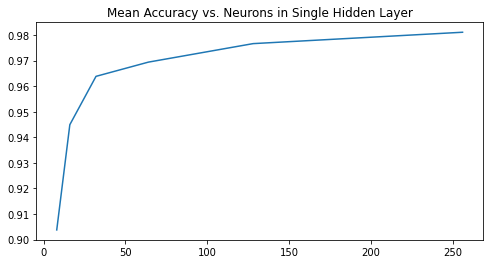

In [11]:
# using 4-fold cross validation with different hidden layers
nn_one_neurons = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)
]
nn_accuracies = []
for n in nn_one_neurons:
    mlp_accuracies = cross_validate(n)
    mlp_mean_accuracy = np.mean(mlp_accuracies)
    nn_accuracies.append(mlp_mean_accuracy)
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons in Single Hidden Layer")
x = [i[0] for i in nn_one_neurons]
plt.plot(x, nn_accuracies)
plt.show()

- There is an improvement in the accuracy by adding more neurons to the single hidden layer from 86% to 94%
- The accuracy calculated doesn't tell about the false or true positives or false or true negatives
- The KNN model already achieved 96% accuracy. Single Hidden Layer using neural network doesn't have advantage over the former.

### Double Hidden Layer Neural Network
Two hidden layers are used and continue to increase the number of neurons with each layer.
Using 4-fold cross validation to train model using two hidden layers.
- Using 64 neurons in the first hidden layer and 64 neurons in the second hidden layer
- Rank the performance of the models with overall accuracies
- Overfitting of model, where we compute and visualize the performance for both train and test sets to check their divergence

In [12]:
# test nn with 2 hidden layers both with 64 neurons
mlp_accuracies = cross_validate((64,64))
mlp_mean_accuracies = np.mean(mlp_accuracies)
print(mlp_mean_accuracy)

0.9810863647611978


/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizati

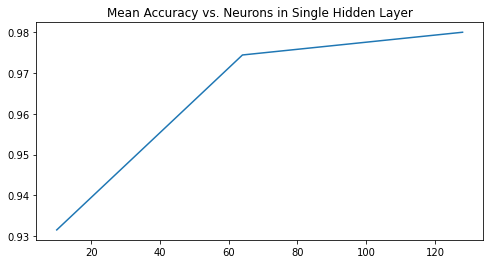

In [13]:
# edit the code above to use 2 Hidden Layers
nn_two_neurons = [
    (10,10),
    (64, 64),
    (128, 128)
]
nn_two_accuracies = []

for n in nn_two_neurons:
    mlp_accuracies = cross_validate(n)
    mlp_mean_accuracy = np.mean(mlp_accuracies)
    nn_two_accuracies.append(mlp_mean_accuracy)
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons in Single Hidden Layer")
x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_accuracies)
plt.show()

- The simple accuracy improves to 95% using two hidden layers.
- The 4 fold cross validation gives assurance that the model
- This is achieving extra 1% over the single accuracy over SHL network

### Triple Hidden Layer

In [14]:
def cross_validate(neurons):
    fold_accuracies =[]
    kf = KFold(n_splits = 6, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(digits_df):
        train_features, test_features = digits_df.loc[train_index], digits_df.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        model = train_nn(neurons, train_features, train_labels)
        overall_accuracy = test_nn(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

# def cross_validate_six(neuron_arch):
#     fold_accuracies = []
#     kf = KFold(n_splits=6, random_state=2,shuffle=True)
#     for train_index, test_index in kf.split(data):
#         train_features, test_features = data.loc[train_index], data.loc[test_index]
#         train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
#         model = train_nn(neuron_arch, train_features, train_labels)
#         overall_accuracy = test(model, test_features, test_labels)
#         fold_accuracies.append(overall_accuracy)
#     return fold_accuracies

/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niccolog/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizati

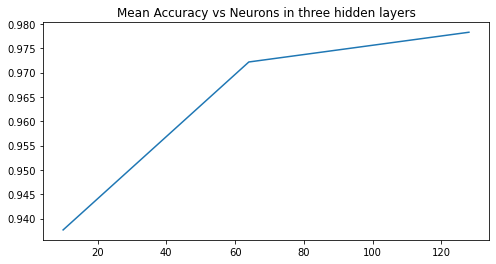

In [15]:
nn_three_neurons = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]

nn_three_accuracies = []

for n in nn_three_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_three_accuracies.append(nn_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs Neurons in three hidden layers")

x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracies)